# First modelling tests 

Some examples found in python 

https://github.com/DP6/Marketing-Attribution-Models
https://victorangeloblancada.github.io/blog/2019/01/01/channel-attribution-in-python.html
https://colab.research.google.com/github/iampatgrady/Simple-Probabalistic-Model-For-Google-Analytics-Users/blob/master/Multitouch_Attribution_Modeling.ipynb#scrollTo=EgwqXCQ3tgM5


In [1]:
import requests
import urllib.parse as up
import json
from pandas.io.json import json_normalize
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import constants_year_MT 
import importlib # to reload the constants module. Necessary if we do changes in module 
import seaborn as sns

## Import data

TODO: add some new features

In [2]:
# import basic table containing time data 
importlib.reload(constants_year_MT)
from constants_year_MT import url_12months_complete_time_til_june
response_basic_june = requests.get(url_12months_complete_time_til_june)
print(response_basic_june)

# importlib.reload(constants_year_MT)
from constants_year_MT import url_12months_complete_time_til_dec
response_basic_dec = requests.get(url_12months_complete_time_til_dec)
print(response_basic_dec)

<Response [200]>
<Response [200]>


### Create table from url data 

In [5]:
# function to create dataframe from url data 
def url_to_df (url, response): 
    """
    Function to create pandas dataframe from url data. Imported data needs 
    to be of type json or keyjson. Otherwise an exception error is thrown

    Arguments: 
        url: url previously imported from constants file 
        response: previously extracted response 

    Returns: 
        df2: supermetrics information transformed into pandas dataframe 
    """

    if 'data/json?' in url:
        # convert json into pandas df 
        data = json.loads(json.dumps(response.json()))
        df = pd.DataFrame.from_dict(data['data'])
        headers = df.iloc[0]
        df2 = pd.DataFrame(df.values[1:], columns=headers)
    elif 'data/keyjson?' in url:
        # convert json key-value pair output to pandas df 
        df2 = pd.read_json(json.dumps(response.json()))
    else:
        # throw exception message 
        import sys
        sys.exit("DEFINE JSON OR KEYJSON AS OUTPUT FORMAT: https://supermetrics.com/docs/product-api-output-formats/")
    return df2     

In [4]:
df_basic1 = url_to_df(url_12months_complete_time_til_june, response_basic_june)
df_basic2 = url_to_df(url_12months_complete_time_til_dec, response_basic_dec)

# concatenate tables and make copy to work with 
frames = [df_basic1, df_basic2]
df_basic = pd.concat(frames)
df = df_basic

## Data preprocessing 

* Transform data to correct format 
* Create feature of path order, indicating how many paths exist per clientID. To be used at attribution modelling
* Create feature of new/old client in 2021, using path_order

### Data preprocessing to create `df_eda`

In [6]:
# combine hour + minute 
df['Time'] = (pd.to_datetime(df['Hour'].astype(str) + ':' + df['Minute'].astype(str), format='%H:%M').dt.time)

# drop redundant features 
df.drop('Hour', axis = 1, inplace = True)
df.drop('Minute', axis = 1, inplace = True)

In [7]:
# function to convert data to correct format
def transform_class (df, feats_to_convert):
    for f in feats_to_convert: 
        if f in ['Date', 'Time']:
            df[f] = pd.to_datetime(df[f])
        #elif f == 'Time': 
        #    df[f] = pd.to_datetime(df[f], format='%H:%M:%S')
        else: # all numeric 
            df[f] = pd.to_numeric(df[f], errors = 'coerce')
    return df

feats_to_convert = ['Date', 'Transactions', 'Transaction revenue', 'Pageviews', 'Total time on site', 'Users']
df = transform_class(df, feats_to_convert)

In [8]:
# reorder columns 
df = df[['clientID', 'Date', 'Time', 'Transactions', 'Transaction revenue', 'Channel group', 'Operating system', 'Source', 'Medium', 'Total time on site', 'Pageviews', 'Users']]

# reorder table by clientID, Date and Time 
df = df.sort_values(['clientID', 'Date', 'Time'])

# extract information about first time with total time on site (which can be found on first row) + last time + rename columns 
df_firsttime = df.groupby(['clientID', 'Date', 'Channel group'], as_index = False)['Time'].first()
df_firsttime.rename(columns = {'Time':'time_start'}, inplace = True)
df_lasttime = df.groupby(['clientID', 'Date', 'Channel group'], as_index = False)['Time'].last()
df_lasttime.rename(columns = {'Time':'time_end'}, inplace = True)

# 'outer' keeps both, merge on all feats to avoid redundancy in merged dataset 
df_first_and_last = pd.merge(left = df_firsttime, right = df_lasttime, how = 'outer', on = ['clientID', 'Date', 'Channel group'])
df_first_and_last = df_first_and_last.drop_duplicates() # those where Time (First) and time (last) are the same 
df_first_and_last.head()

# transform date + time into timestamp. Takes a while (~5m)
df_first_and_last['timestamp_start'] = pd.to_datetime(df_first_and_last.Date.apply(str) + ' ' + df_first_and_last.time_start.apply(str))
df_first_and_last['timestamp_end'] = pd.to_datetime(df_first_and_last.Date.apply(str) + ' ' + df_first_and_last.time_end.apply(str))

# calculate difference between both timestamps - in minutes
df_first_and_last['timestamp_diff'] = (df_first_and_last['timestamp_end'] - df_first_and_last['timestamp_start']).astype('timedelta64[m]')

Because each pageview appears as a new row, some redundancy exists in the dataset. In order to get rid of it, we will group by the categorical features ('clientID', 'Date', 'Channel group', 'Operating system', 'Source','Medium') and calculate the sum of the other features (like 'Total time on site' and 'Pageviews'). We need to finally create Users again, i.e. substitute it with "1". 

In [16]:
# get rid of redundancy in dataset
new_df = df 
new_df = new_df.groupby(['clientID', 'Date', 'Channel group', 'Operating system', 'Source','Medium']).sum()
new_df = new_df.reset_index()
# new_df 

# merge with original dataset, keeping rows from df_first_and_last 
new_df = pd.merge(left = new_df, right = df_first_and_last, how = 'left', on = ['clientID', 'Date', 'Channel group'])
# df_final 

In [17]:
# create features 

# create path order per clientID and date 
new_df['path_order'] = new_df.groupby('clientID').cumcount() + 1
new_df['path_order_by_date'] = new_df.groupby(['clientID', 'Date']).cumcount() + 1

# create feature of new/old client in 2021
## new => path_order = 1
## old => path_order > 1
new_df['type_of_client_by_path_order'] = (new_df.path_order > 1).astype('int')
# change categories 
new_df.type_of_client_by_path_order[new_df.type_of_client_by_path_order == 1] = 'old_by_path_order'
new_df.type_of_client_by_path_order[new_df.type_of_client_by_path_order == 0] = 'new_by_path_order'

# check result 
# df_final.value_counts(['path_order', 'type_of_client_by_path_order'])

# create feature of new/old client - grouping information + merge with original dataset 
new_old_client = new_df[['clientID', 'Date', 'path_order']]
new_old_client = new_old_client.sort_values(['clientID', 'path_order'])
# just keep last one 
new_old_client = new_old_client.drop_duplicates('clientID', keep = 'last')
new_old_client['general_type_of_client'] = (new_old_client.path_order > 1).astype('int')
# change name of categories 
new_old_client.general_type_of_client[new_old_client.general_type_of_client == 1] = 'old_in_2021'
new_old_client.general_type_of_client[new_old_client.general_type_of_client == 0] = 'new_in_2021'

# drop features not needed - all except clientID and general_type_of_client, to be able to merge them with the original dataset
new_old_client.drop(['Date', 'path_order'], axis = 1, inplace = True)
new_df = pd.merge(new_df, new_old_client, how = 'left', on = ('clientID'))
# print('Original number of transactions: ')
# new_df.Transactions.sum()

# extract month of touchpoint/transaction 
new_df['Date_month'] = new_df['Date'].dt.month

C:\Users\carol\AppData\Local\Temp\ipykernel_18152\3105914518.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.type_of_client_by_path_order[new_df.type_of_client_by_path_order == 1] = 'old_by_path_order'
C:\Users\carol\AppData\Local\Temp\ipykernel_18152\3105914518.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_old_client.general_type_of_client[new_old_client.general_type_of_client == 1] = 'old_in_2021'


In [13]:
# check and drop missing data 
print(new_df.isna().sum()) # no missing data 
new_df = new_df.dropna()

0
clientID                        0
Date                            0
Channel group                   0
Operating system                0
Source                          0
Medium                          0
Transactions                    0
Transaction revenue             0
Total time on site              0
Pageviews                       0
Users                           0
time_start                      0
time_end                        0
timestamp_start                 0
timestamp_end                   0
timestamp_diff                  0
path_order                      0
path_order_by_date              0
type_of_client_by_path_order    0
general_type_of_client          0
dtype: int64


In EDA process we have studied why we should drop cases of clientIDs that visit the website through the Bewerberportal and how we should also drop the data from #GivingTuesday

In [22]:
# drop cases - apply to job and GivingTuesday 
karriere1 = new_df[new_df['Source'] == 'sos-kinderdorf.bewerberportal.at']['clientID']
new_df = new_df[-new_df['clientID'].isin(karriere1)]
df_eda = new_df[new_df['Date'] != '2021-11-30']

# Imputer users = 1 per row (i.e. per website visit)
df_eda['Users'] = 1

# reorder table by clientID, Date and time_start 
df_eda = df_eda.sort_values(['clientID', 'timestamp_start'])
df_eda.head()

C:\Users\carol\AppData\Local\Temp\ipykernel_18152\171143325.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eda['Users'] = 1


,clientID,Date,Channel group,Operating system,Source,Medium,Transactions,Transaction revenue,Total time on site,Pageviews,Users,time_start,time_end,timestamp_start,timestamp_end,timestamp_diff,path_order,path_order_by_date,type_of_client_by_path_order,general_type_of_client
0,1000005671.1568444004,2021-01-04,Display,Android,google,cpc,0,0.0,0,1,1,22:30:00,22:30:00,2021-01-04 22:30:00,2021-01-04 22:30:00,0.0,1,1,new_by_path_order,new_in_2021
1,1000006728.1622927843,2021-06-05,Direct,iOS,(direct),(none),0,0.0,0,1,1,23:17:00,23:17:00,2021-06-05 23:17:00,2021-06-05 23:17:00,0.0,1,1,new_by_path_order,new_in_2021
2,1000020259.1556972396,2021-01-31,Referral,Android,trafficbot.life,referral,0,0.0,0,1,1,19:57:00,19:57:00,2021-01-31 19:57:00,2021-01-31 19:57:00,0.0,1,1,new_by_path_order,new_in_2021
4,1000024791.1630470945,2021-09-01,Branded Paid Search,iOS,google,cpc,0,0.0,38,2,1,06:35:00,06:36:00,2021-09-01 06:35:00,2021-09-01 06:36:00,1.0,1,1,new_by_path_order,new_in_2021
5,1000025674.1610314739,2021-01-10,Organic Search,Windows,google,organic,0,0.0,0,1,1,22:38:00,22:40:00,2021-01-10 22:38:00,2021-01-10 22:40:00,2.0,1,1,new_by_path_order,new_in_2021


### Data preprocessing for attribution modelling 

**Create paths per clientID**

* We need to create a table that contains the path (order) for users that have interacted with different channels along the year 2021.
* For those visitors with more than one transaction, we have to split the paths  
* A reduced set of features was selected
* As we can observe, some entry errors probably exist - with very big path orders (which probably correspond to the same clientID)
* From the original ~ 350.000 unique clientIDS, 74.759 appear more than once in the dataset. We have to take into account that we are just checking 1 year timeframe - in other words, (potential) donors may have checked the webpage before 01.01.2021. That information should be contained in feature "user type", but Im not sure it I will do something with it

Example based on https://www.kaggle.com/code/hughhuyton/multitouch-attribution-modelling/notebook

Create path_counter, representing the number of path for those cases with at least one transaction and at least > 1 touchpoint. Possible cases include: 
* Transactions = 1 & path_order = 1 -> path_counter = 1 (can be directly done, no loop needed)
* Transactions = 0 & path_order = 1 -> path_counter = 1 (can be directly done, no loop needed)
* Transactions = 0 & path_order > 1 -> path_counter = 1 (can be directly done, no loop needed)
* Transactions >= 1 & path_order > 1 ->  path_counter >= 1 (need loop)

We tried to do a loop that would assign the path_counter to each clientID in the table. However, the process was too slow so we decided to apply the loop to just the "really" necessary cases (those with path_counter >= 1). 

In [ ]:
# Apply to dataset with transactions and more than one channel group 
# otherwise the loop takes too long 
df_sub = df_eda[(df_eda['Transactions'] > 0) & (df_eda['path_order'] > 1)]
client_list = df_sub['clientID'].unique()
print(len(client_list))

# extract reduced dataset of clients in client_list. This will make loop faster
client_df_original = df_eda[df_eda['clientID'].isin(client_list)]

path_counter = []

for client in client_list: 
    # reset path number 
    path_number = 1
    # extract data 
    client_df = client_df_original[client_df_original['clientID'] == client]
    # sort table 
    client_df = client_df.sort_values(['clientID', 'timestamp_start', 'timestamp_end'])
    #print(client_df)
    if len(client_df) == 1: # nvm if Transaction = 0 or > 0
        # path_number = 1
        path_counter.append(path_number)
    else: # len > 1 
        for i in range(0,len(client_df)): 
            if client_df.iloc[i]['Transactions'] == 0: 
                # keep same path_counter 
                path_number = path_number
                path_counter.append(path_number)
            else: # if transaction exist 
                # keep same path counter but update it afterwards 
                path_counter.append(path_number)
                path_number += 1

# add path_counter into client_df_original 
client_df_original['path_counter'] = path_counter

# create table sub_df2 with clients without any transaction or with transaction but with path_order = 1 (just one touchpoint)
sub_df2 = df_eda[df_eda.clientID.isin(client_list) == False]
sub_df2['path_counter'] = 1

# concatenate both data tables 
df_merge = [sub_df2, client_df_original]
df_merge = pd.concat(df_merge) 
# df_merge

In [ ]:
# add info about number of touchpoints per path 
test1 = df_merge.groupby(['clientID', 'path_counter'])['clientID'].count() 
test1 = test1.to_frame()
test1.rename({'clientID':'touchpoints_number'}, axis = 1, inplace = True)
test1 = test1.reset_index()

# add into df_merge 
df_merge = pd.merge(left = df_merge, right = test1, how = 'left', on = ['clientID', 'path_counter'])

# order by timestamps 
df_merge = df_merge.sort_values(['clientID', 'timestamp_start', 'timestamp_end'])
# df_merge

In [36]:
df_merge

,clientID,Date,Channel group,Operating system,Source,Medium,Transactions,Transaction revenue,Total time on site,Pageviews,...,time_end,timestamp_start,timestamp_end,timestamp_diff,path_order,path_order_by_date,type_of_client_by_path_order,general_type_of_client,path_counter,touchpoints_number
0,1000005671.1568444004,2021-01-04,Display,Android,google,cpc,0,0.0,0,1,...,22:30:00,2021-01-04 22:30:00,2021-01-04 22:30:00,0.0,1,1,new_by_path_order,new_in_2021,1,1
1,1000006728.1622927843,2021-06-05,Direct,iOS,(direct),(none),0,0.0,0,1,...,23:17:00,2021-06-05 23:17:00,2021-06-05 23:17:00,0.0,1,1,new_by_path_order,new_in_2021,1,1
2,1000020259.1556972396,2021-01-31,Referral,Android,trafficbot.life,referral,0,0.0,0,1,...,19:57:00,2021-01-31 19:57:00,2021-01-31 19:57:00,0.0,1,1,new_by_path_order,new_in_2021,1,1
3,1000024791.1630470945,2021-09-01,Branded Paid Search,iOS,google,cpc,0,0.0,38,2,...,06:36:00,2021-09-01 06:35:00,2021-09-01 06:36:00,1.0,1,1,new_by_path_order,new_in_2021,1,1
4,1000025674.1610314739,2021-01-10,Organic Search,Windows,google,organic,0,0.0,0,1,...,22:40:00,2021-01-10 22:38:00,2021-01-10 22:40:00,2.0,1,1,new_by_path_order,new_in_2021,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427883,999973068.1611254848,2021-01-21,Display,Android,google,cpc,0,0.0,0,1,...,19:45:00,2021-01-21 19:45:00,2021-01-21 19:45:00,0.0,1,1,new_by_path_order,new_in_2021,1,1
427884,99997309.1608586309,2021-01-04,Display,Android,google,cpc,0,0.0,0,1,...,16:48:00,2021-01-04 16:48:00,2021-01-04 16:48:00,0.0,1,1,new_by_path_order,new_in_2021,1,1
427885,999988377.1636720143,2021-11-12,Display,Windows,google,cpc,0,0.0,0,1,...,13:29:00,2021-11-12 13:29:00,2021-11-12 13:29:00,0.0,1,1,new_by_path_order,new_in_2021,1,1
427886,999996741.1623865085,2021-06-16,(Other),Android,facebook,darkpost,0,0.0,0,1,...,19:38:00,2021-06-16 19:38:00,2021-06-16 19:38:00,0.0,1,1,new_by_path_order,new_in_2021,1,1


(?) Does it make sense to work with those with just 1 touchpoint (274.925)? Not sure about that yet 

In [ ]:
# create df of model - grouping by clientID and path_counter 
df_model = df_merge.groupby(['clientID', 'path_counter', 'touchpoints_number']).sum().reset_index() #.sum(['Transactions', 'Transaction revenue'])

# create df of paths 
df_paths = df_merge.groupby(['clientID', 'path_counter', 'touchpoints_number'])['Channel group'].apply(lambda x: ' > '.join(x)).reset_index()

# add path information to df_model, using clientID and path_counter to join tables 
df_model = pd.merge(left = df_model, right = df_paths, how = 'left', on = ['clientID', 'path_counter', 'touchpoints_number'])
# print(df_model)
print(df_model.touchpoints_number.value_counts())

TODO: compare this results with latex document

In [34]:
print('Number of unique clientIDs in table of paths: ', df_model['clientID'].nunique()) # 329906
print('Total number of transactions in table of paths: ', df_model['Transactions'].sum()) # 6535
print('Total number of paths: ', len(df_model)) # 330506, number of paths 

Number of unique clientIDs in table of paths:  329906
Total number of transactions in table of paths:  6535
Total number of paths:  330506


In [35]:
df_model

,clientID,path_counter,touchpoints_number,Transactions,Transaction revenue,Total time on site,Pageviews,Users,timestamp_diff,path_order,path_order_by_date,Channel group
0,1000005671.1568444004,1,1,0,0.0,0,1,1,0.0,1,1,Display
1,1000006728.1622927843,1,1,0,0.0,0,1,1,0.0,1,1,Direct
2,1000020259.1556972396,1,1,0,0.0,0,1,1,0.0,1,1,Referral
3,1000024791.1630470945,1,1,0,0.0,38,2,1,1.0,1,1,Branded Paid Search
4,1000025674.1610314739,1,1,0,0.0,0,1,1,2.0,1,1,Organic Search
...,...,...,...,...,...,...,...,...,...,...,...,...
330501,999973068.1611254848,1,1,0,0.0,0,1,1,0.0,1,1,Display
330502,99997309.1608586309,1,1,0,0.0,0,1,1,0.0,1,1,Display
330503,999988377.1636720143,1,1,0,0.0,0,1,1,0.0,1,1,Display
330504,999996741.1623865085,1,1,0,0.0,0,1,1,0.0,1,1,(Other)


## Modelling trial I: heuristic approach 

**Last-touch attribution modelling** - it just needs the conversions 

TODO: check this, does it just work with conversions? 

### Last-touch attribution, by hand 

          Channel group  Transactions
0               (Other)            13
1   Branded Paid Search          2056
2                Direct           815
3               Display            23
4                 Email           874
5   Generic Paid Search           877
6        Organic Search          1690
7           Paid Search             1
8              Referral           147
9                Social            36
10          YouTube Ads             3


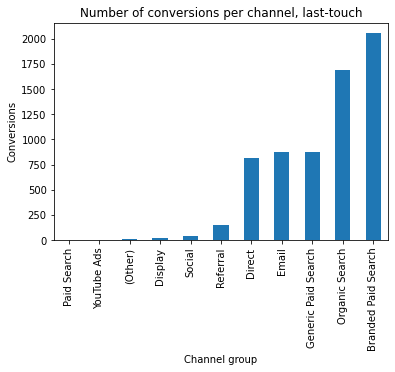

In [52]:
# results for all journeys 

# extract table of Transactions > 0
df_lasttouch = df_merge[df_merge['Transactions'] > 0]
# df_lasttouch

# check transactions assigned to each channel group 
df_lasttouch_review = df_lasttouch.groupby('Channel group')['Transactions'].sum().to_frame().reset_index()
print(df_lasttouch_review)

df_lasttouch_review.sort_values('Transactions').plot(x = 'Channel group', y = 'Transactions', kind = 'bar')
plt.ylabel('Conversions')
plt.title('Number of conversions per channel, last-touch')
plt.legend('', frameon = False)
plt.show()

In [87]:
# print(df_lasttouch['Transactions'].sum()) # 6535
# print(df_merge['Transactions'].sum()) # 6535
# print(df_model['Transactions'].sum()) # 6535
# print(df_attribution['Transactions'].sum()) # 6535

6535
6535
6535
6535


         Channel group  Transactions
0              (Other)             3
1  Branded Paid Search           482
2               Direct           134
3              Display            10
4                Email           218
5  Generic Paid Search           190
6       Organic Search           424
7             Referral            82
8               Social            12
9          YouTube Ads             1


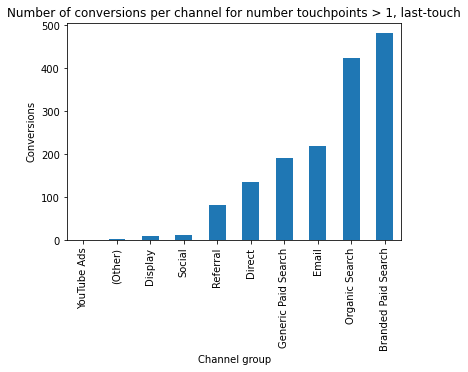

In [53]:
df_touchpoints_number_over1 = df_merge[df_merge['touchpoints_number'] > 1]
df_lasttouch_touchpoints_number_over1 = df_touchpoints_number_over1[df_touchpoints_number_over1['Transactions'] > 0]
df_lasttouch_touchpoints_number_over1_review = df_lasttouch_touchpoints_number_over1.groupby('Channel group')['Transactions'].sum().to_frame().reset_index()
print(df_lasttouch_touchpoints_number_over1_review)

df_lasttouch_touchpoints_number_over1_review.sort_values('Transactions').plot(x = 'Channel group', y = 'Transactions', kind = 'bar')
plt.ylabel('Conversions')
plt.title('Number of conversions per channel for number touchpoints > 1, last-touch')
plt.legend('', frameon = False)
plt.show()

### Last-touch attribution, with `ChannelAttribution` v2.1.2 package

In [56]:
import ChannelAttribution

Looking for attribution at path level? Try markov_model_local_api() or ask for ChannelAttributionPro at info@channelattribution.io! Visit https://channelattribution.io for more information.
Version: 2.1.3


In order to use the package {ChannelAttribution}, we need to create a table of aggregated data per path. We need to take into account that more than one transaction can be done within the same path i.e. touchpoint. 

We need to split the table into several ones to extract that information 

(!) I think result is the same as if doing it directly

In [ ]:
# counter of paths with Transactions > 1
table1 = df_model[df_model['Transactions'] > 1]
table1['counter_paths_with_transactions'] = 1
table1['counter_paths_without_transactions'] = 0

# counter of paths with Transactions == 1
table2 = df_model[df_model['Transactions'] == 1]
table2['counter_paths_with_transactions'] = 1
table2['counter_paths_without_transactions'] = 0

# counter of paths with Transactions == 0 
table3 = df_model[df_model['Transactions'] == 0]
table3['counter_paths_without_transactions'] = 1
table3['counter_paths_with_transactions'] = 0

# concatenate tables  
frames = [table1, table2, table3]
df_attribution = pd.concat(frames, join = 'outer')
# df_attribution

TODO: substitute "Channel group" with "path"

In [82]:
df_attribution = df_attribution[['Transactions', 'Transaction revenue', 'Channel group', 'counter_paths_without_transactions']]
df_attribution = df_attribution.groupby('Channel group').sum().reset_index()
df_attribution 

,Channel group,Transactions,Transaction revenue,counter_paths_without_transactions
0,(Other),10,1351.0,9668
1,(Other) > (Other),0,0.0,803
2,(Other) > (Other) > (Other),0,0.0,129
3,(Other) > (Other) > (Other) > (Other),1,210.0,42
4,(Other) > (Other) > (Other) > (Other) > (Other),0,0.0,20
...,...,...,...,...
2589,YouTube Ads > YouTube Ads > YouTube Ads > YouT...,0,0.0,1
2590,YouTube Ads > YouTube Ads > YouTube Ads > YouT...,0,0.0,1
2591,YouTube Ads > YouTube Ads > YouTube Ads > YouT...,0,0.0,1
2592,YouTube Ads > YouTube Ads > YouTube Ads > YouT...,0,0.0,1


In [195]:
df_attribution.sort_values('Transactions', ascending = False)

,Channel group,Transactions,Transaction revenue,counter_paths_without_transactions
104,Branded Paid Search,1574,258009.76,22045
1423,Organic Search,1266,259802.15,101700
1241,Generic Paid Search,687,74003.87,28705
495,Direct,681,112096.02,25002
1105,Email,656,57406.64,7429
...,...,...,...,...
894,Direct > Referral > Branded Paid Search > Bran...,0,0.00,2
895,Direct > Referral > Branded Paid Search > Soci...,0,0.00,1
896,Direct > Referral > Email,0,0.00,1
897,Direct > Referral > Generic Paid Search,0,0.00,2


(!) I am a little confused that the results do not agree 100% with the ones I obtained by hand 

In [89]:
m1_heuristics = ChannelAttribution.heuristic_models(Data = df_attribution, var_path = 'Channel group', var_conv = 'Transactions', var_value = 'Transaction revenue')
# m1_heuristics['last_touch_conversions'].sum()
m1_heuristics

,channel_name,first_touch_conversions,first_touch_value,last_touch_conversions,last_touch_value,linear_touch_conversions,linear_touch_value
0,(Other),16.0,2151.00,14.0,1807.00,15.126935,1975.991862
1,Email,861.0,84749.64,920.0,100251.46,888.277896,92188.258121
2,Display,26.0,3156.50,51.0,5046.50,41.782200,4222.547448
3,Social,36.0,2261.00,35.0,2513.00,37.402473,2452.303473
4,Organic Search,1640.0,319605.05,1708.0,336122.73,1675.289299,328154.575469
5,YouTube Ads,2.0,275.00,4.0,695.00,3.000000,485.000000
6,Branded Paid Search,2008.0,395770.21,2010.0,388241.51,2012.809062,393068.111596
7,Direct,904.0,142433.62,781.0,127500.12,839.751151,134431.443821
8,Referral,122.0,23213.40,171.0,24734.40,143.719881,23921.590089
9,Generic Paid Search,919.0,103831.18,840.0,90534.88,876.841103,96546.778120


## Modelling trial II: Markov Chain 

**Results for all data**

Apparently there are Markov Chains and Hidden Markov Chains. Not sure which one belongs here 

Ressources: 

- Markov Chains done by hand: https://towardsdatascience.com/marketing-channel-attribution-with-markov-chains-in-python-part-2-the-complete-walkthrough-733c65b23323 
- Channel Attribution package: https://channelattribution.io/pdf/PythonChannelAttribution.pdf 

### Markov Chain with `ChannelAttribution` package

- Approach to the atttribution model in a probabilistic way 
- It uses a k-order Markov representation to identify structural correlations in the customer journey data. This allows advertisers to give a more reliable assessment of the marketing contribution of each channel 
- Approach follows Anderl, Becker, Wangenheim, Schumann 2014 

#### Results for MM order = 1, all donor journeys 

With order = 1, we can represent it in a transition matrix. Otherwise not really

In [124]:
m2_mm = ChannelAttribution.markov_model(Data = df_attribution, 
                                        var_path = 'Channel group', 
                                        var_conv = 'Transactions', 
                                        var_null = 'counter_paths_without_transactions', 
                                        var_value = 'Transaction revenue',
                                        out_more = True)

Number of simulations: 100000 - Reaching convergence (wait...): 18.00% > 5.00%
Number of simulations: 150000 - Reaching convergence (wait...): 13.37% > 5.00%
Number of simulations: 225000 - Reaching convergence (wait...): 10.25% > 5.00%
Number of simulations: 337500 - Reaching convergence (wait...): 9.33% > 5.00%
Number of simulations: 506250 - Reaching convergence (wait...): 8.23% > 5.00%
Number of simulations: 759375 - Reaching convergence (wait...): 7.20% > 5.00%
Number of simulations: 1139062 - Reaching convergence (wait...): 6.24% > 5.00%
Number of simulations: 1708593 - Reaching convergence (wait...): 5.59% > 5.00%
Number of simulations: 2562889 - Convergence reached: 4.96% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (47) is reached: 99.99%


In [170]:
m2_mm_result_table = m2_mm['result']
m2_mm_transition_probs = m2_mm['transition_matrix']
m2_mm_removal_effects = m2_mm['removal_effects']

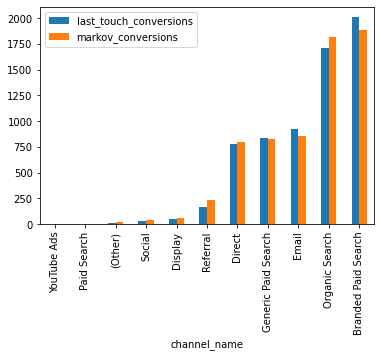

In [137]:
# merge results with heuristic ones 
m2_mm_result_table.rename({'total_conversions':'markov_conversions', 'total_conversion_value':'markov_value'}, axis = 1, inplace = True)
results_models = pd.merge(left = m1_heuristics, right = m2_mm_result_table, on = 'channel_name', how = 'left')
# print(results_models)
plot_data = results_models[['channel_name', 'last_touch_conversions', 'last_touch_value', 'markov_conversions', 'markov_value']]
plot_data.sort_values('markov_conversions').plot(x = 'channel_name', y = ['last_touch_conversions', 'markov_conversions'], kind = 'bar')
plt.show()


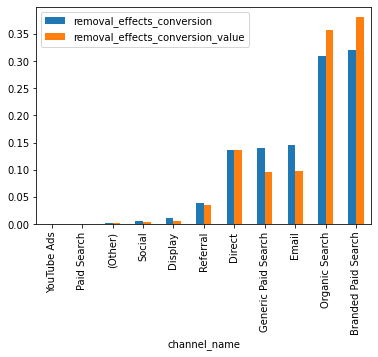

In [136]:
m2_mm_removal_effects.sort_values('removal_effects_conversion').plot(x = 'channel_name', y = ['removal_effects_conversion', 'removal_effects_conversion_value'], kind = 'bar')
# plt.legend(bbox_to_anchor=(0,1.02), loc="lower left")
plt.show()

(!) I want to think that channel numbers correspond to channel_name + 1 (because 0 is START)

In [173]:
# adapted code from https://www.kaggle.com/code/koushiktcs12/attribution-modeling-in-marketing-python/notebook 
m2_mm_transition_probs = m2_mm['transition_matrix']

# Convert start and conversion event to numeric values so we can sort and iterate through
# start = 0 
# conversion = 21
m2_mm_transition_probs.replace('(null)', '22', inplace=True)

# Get unique origin and destination channels
channel_from_unique = m2_mm_transition_probs['channel_from'].unique().tolist()
channel_from_unique.sort(key=float)
channel_to_unique = m2_mm_transition_probs['channel_to'].unique().tolist()
channel_to_unique.sort(key=float)

# Create new matrix (empty) with origin and destination channels as columns and index
m2_mm_trans_matrix = pd.DataFrame(columns=channel_to_unique, index=channel_from_unique)
# m2_mm_trans_matrix 

# Assign the probabilities to the corresponding cells in our transition matrix
for f in channel_from_unique:
    for t in channel_to_unique:
        x = m2_mm_transition_probs[(m2_mm_transition_probs['channel_from'] == f) & (m2_mm_transition_probs['channel_to'] == t)]
        prob = x['transition_probability'].values
        if prob.size > 0:
            m2_mm_trans_matrix[t][f] = prob[0]
        else:
            m2_mm_trans_matrix[t][f] = 0

# Convert all probabilities to floats
m2_mm_trans_matrix = m2_mm_trans_matrix.apply(pd.to_numeric)

# Rename our start and conversion events
m2_mm_trans_matrix.rename(index={'0': 'START'}, inplace=True)
m2_mm_trans_matrix.rename(index={'1': '(Other)'}, inplace=True)
m2_mm_trans_matrix.rename(index={'2': 'Email'}, inplace=True)
m2_mm_trans_matrix.rename(index={'3': 'Display'}, inplace=True)
m2_mm_trans_matrix.rename(index={'4': 'Social'}, inplace=True)
m2_mm_trans_matrix.rename(index={'5': 'Organic'}, inplace=True)
m2_mm_trans_matrix.rename(index={'6': 'Youtube'}, inplace=True)
m2_mm_trans_matrix.rename(index={'7': 'Branded'}, inplace=True)
m2_mm_trans_matrix.rename(index={'8': 'Direct'}, inplace=True)
m2_mm_trans_matrix.rename(index={'9': 'Referral'}, inplace=True)
m2_mm_trans_matrix.rename(index={'10': 'Generic'}, inplace=True)
m2_mm_trans_matrix.rename(index={'11': 'Paid search'}, inplace=True)

m2_mm_trans_matrix.rename(columns={'21': 'CONVERSION'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'22': 'NULL'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'0': 'START'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'1': '(Other)'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'2': 'Email'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'3': 'Display'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'4': 'Social'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'5': 'Organic'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'6': 'Youtube'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'7': 'Branded'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'8': 'Direct'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'9': 'Referral'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'10': 'Generic'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'11': 'Paid search'}, inplace=True)


Transition matrix show probability of state ending up in conversion, no-conversion (Null) or in a different state. 

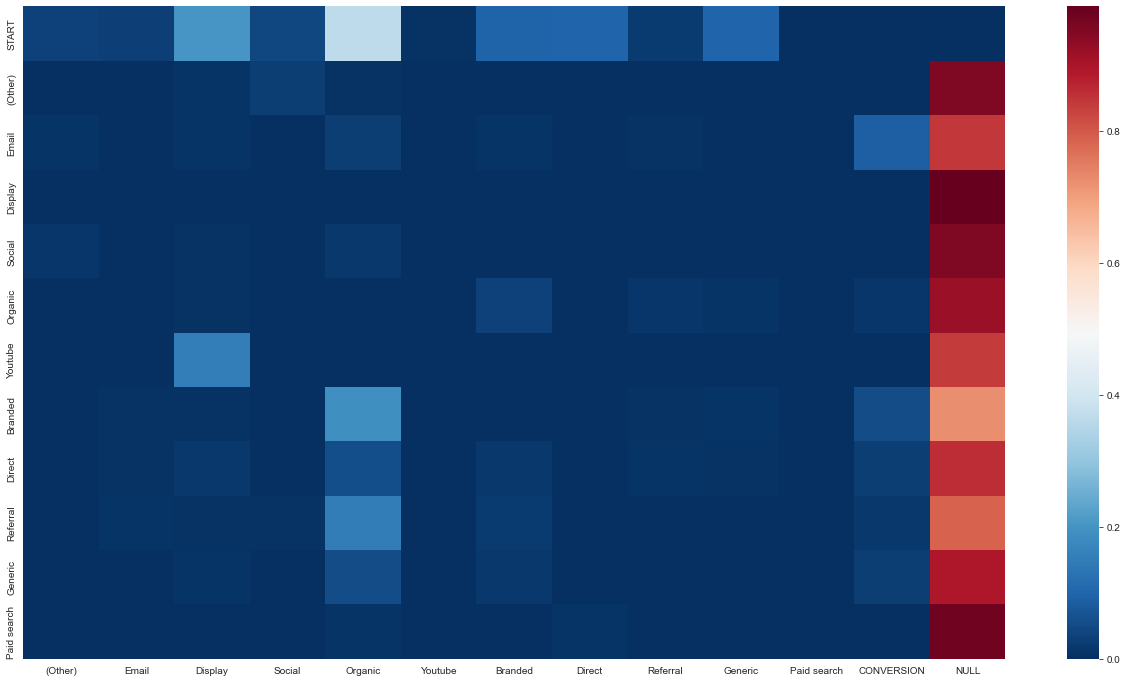

In [175]:
# Visualize this transition matrix in a heatmap
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(22, 12))
sns.heatmap(m2_mm_trans_matrix, cmap="RdBu_r")
plt.show()

In [176]:
m2_mm_trans_matrix

,(Other),Email,Display,Social,Organic,Youtube,Branded,Direct,Referral,Generic,Paid search,CONVERSION,NULL
START,0.033591,0.029564,0.204093,0.043811,0.364358,0.007078,0.094833,0.098799,0.020742,0.099944,0.003187,0.000000,0.000000
(Other),0.000000,0.002336,0.008306,0.025437,0.004326,0.000260,0.001903,0.000346,0.001038,0.000606,0.000000,0.001211,0.954231
Email,0.010336,0.000000,0.010522,0.002235,0.024304,0.000466,0.010336,0.002235,0.006798,0.002421,0.000000,0.085669,0.844678
Display,0.000356,0.000585,0.000000,0.000342,0.002951,0.003422,0.001084,0.000314,0.000171,0.001697,0.000086,0.000727,0.988267
Social,0.011909,0.001757,0.005402,0.000000,0.015619,0.000195,0.003579,0.000325,0.002929,0.000846,0.000065,0.002278,0.955096
Organic,0.000374,0.002833,0.005839,0.002131,0.000000,0.000172,0.034336,0.001338,0.012455,0.008059,0.000045,0.012769,0.919651
Youtube,0.000748,0.000000,0.152263,0.000374,0.002993,0.000000,0.001122,0.000374,0.000000,0.000748,0.000000,0.001496,0.839880
Branded,0.000612,0.004308,0.005744,0.001303,0.192511,0.000186,0.000000,0.001250,0.006356,0.009095,0.000053,0.053453,0.725128
Direct,0.001151,0.006178,0.015960,0.003422,0.056903,0.001090,0.018201,0.000000,0.008873,0.006541,0.000485,0.023652,0.857545
Referral,0.000431,0.008503,0.005274,0.006027,0.149715,0.000108,0.022172,0.001722,0.000000,0.003659,0.000000,0.018405,0.783985


#### Results for MM order = 1, donor journeys with number of touchpoints > 1 

Results in terms of marketing budget allocation for most journeys can be actually done based on a simple explorative analysis. Therefore, we filtered all those paths with touchpoints == 1 and check the results for longer paths. 


In [ ]:
df_model_more_touchpoints = df_model[df_model['touchpoints_number'] > 1]

# counter of paths with Transactions > 1
table1 = df_model_more_touchpoints[df_model_more_touchpoints['Transactions'] > 1]
table1['counter_paths_with_transactions'] = 1
table1['counter_paths_without_transactions'] = 0

# counter of paths with Transactions == 1
table2 = df_model_more_touchpoints[df_model_more_touchpoints['Transactions'] == 1]
table2['counter_paths_with_transactions'] = 1
table2['counter_paths_without_transactions'] = 0

# counter of paths with Transactions == 0 
table3 = df_model_more_touchpoints[df_model_more_touchpoints['Transactions'] == 0]
table3['counter_paths_without_transactions'] = 1
table3['counter_paths_with_transactions'] = 0

# concatenate tables  
frames = [table1, table2, table3]
df_attribution_more_touchpoints = pd.concat(frames, join = 'outer')
# df_attribution

In [178]:
m2_mm_reduced = ChannelAttribution.markov_model(Data = df_attribution_more_touchpoints, 
                                        var_path = 'Channel group', 
                                        var_conv = 'Transactions', 
                                        var_null = 'counter_paths_without_transactions', 
                                        var_value = 'Transaction revenue',
                                        out_more = True)

Number of simulations: 100000 - Reaching convergence (wait...): 10.88% > 5.00%
Number of simulations: 150000 - Reaching convergence (wait...): 9.22% > 5.00%
Number of simulations: 225000 - Reaching convergence (wait...): 7.11% > 5.00%
Number of simulations: 337500 - Reaching convergence (wait...): 6.40% > 5.00%
Number of simulations: 506250 - Reaching convergence (wait...): 5.30% > 5.00%
Number of simulations: 759375 - Convergence reached: 4.72% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (47) is reached: 99.99%


In [180]:
# calculate last touchpoint for df_attribution_more_touchpoints
m1_heuristics_reduced = ChannelAttribution.heuristic_models(Data = df_attribution_more_touchpoints, var_path = 'Channel group', var_conv = 'Transactions', var_value = 'Transaction revenue')
# m1_heuristics['last_touch_conversions'].sum()
m1_heuristics_reduced

,channel_name,first_touch_conversions,first_touch_value,last_touch_conversions,last_touch_value,linear_touch_conversions,linear_touch_value
0,Direct,223.0,30337.60,100.0,15404.10,158.751151,22335.423821
1,Referral,57.0,14041.00,106.0,15562.00,78.719881,14749.190089
2,Organic Search,374.0,59802.90,442.0,76320.58,409.289299,68352.425469
3,Branded Paid Search,434.0,137760.45,436.0,130231.75,438.809062,135058.351596
4,Generic Paid Search,232.0,29827.31,153.0,16531.01,189.841103,22542.908120
5,Email,205.0,27343.00,264.0,42844.82,232.277896,34781.618121
6,Social,12.0,583.00,11.0,835.00,13.402473,774.303473
7,Display,13.0,1706.50,38.0,3596.50,28.782200,2772.547448
8,(Other),6.0,800.00,4.0,456.00,5.126935,624.991862
9,YouTube Ads,0.0,0.00,2.0,420.00,1.000000,210.000000


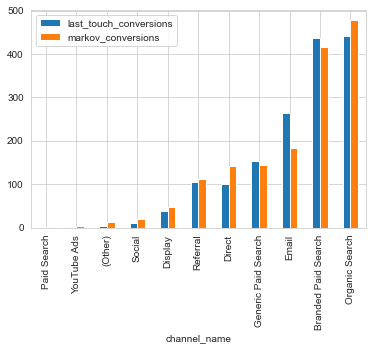

In [182]:
# check results in terms of conversion and conversion value 
m2_mm_result_table = m2_mm_reduced['result']
m2_mm_transition_probs = m2_mm_reduced['transition_matrix']
m2_mm_removal_effects = m2_mm_reduced['removal_effects']

# merge results with heuristic ones 
m2_mm_result_table.rename({'total_conversions':'markov_conversions', 'total_conversion_value':'markov_value'}, axis = 1, inplace = True)
results_models = pd.merge(left = m1_heuristics_reduced, right = m2_mm_result_table, on = 'channel_name', how = 'left')
# print(results_models)
plot_data = results_models[['channel_name', 'last_touch_conversions', 'last_touch_value', 'markov_conversions', 'markov_value']]
plot_data.sort_values('markov_conversions').plot(x = 'channel_name', y = ['last_touch_conversions', 'markov_conversions'], kind = 'bar')
plt.show()


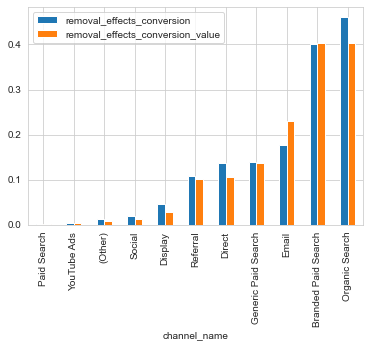

In [183]:
m2_mm_removal_effects.sort_values('removal_effects_conversion').plot(x = 'channel_name', y = ['removal_effects_conversion', 'removal_effects_conversion_value'], kind = 'bar')
# plt.legend(bbox_to_anchor=(0,1.02), loc="lower left")
plt.show()

In [188]:
m2_mm_transition_probs.channel_to.value_counts()

1               11
3               11
4               11
5               11
7               11
8               11
22              11
9               10
10              10
(conversion)    10
6                9
2                9
11               7
Name: channel_to, dtype: int64

In [190]:
# adapted code from https://www.kaggle.com/code/koushiktcs12/attribution-modeling-in-marketing-python/notebook 
m2_mm_transition_probs = m2_mm_reduced['transition_matrix']
# m2_mm_transition_probs
# Convert start and conversion event to numeric values so we can sort and iterate through
m2_mm_transition_probs.replace('(start)', '0', inplace=True)
m2_mm_transition_probs.replace('(conversion)', '21', inplace=True)
m2_mm_transition_probs.replace('(null)', '22', inplace=True)

# Get unique origin and destination channels
channel_from_unique = m2_mm_transition_probs['channel_from'].unique().tolist()
channel_from_unique.sort(key=float)
channel_to_unique = m2_mm_transition_probs['channel_to'].unique().tolist()
channel_to_unique.sort(key=float)

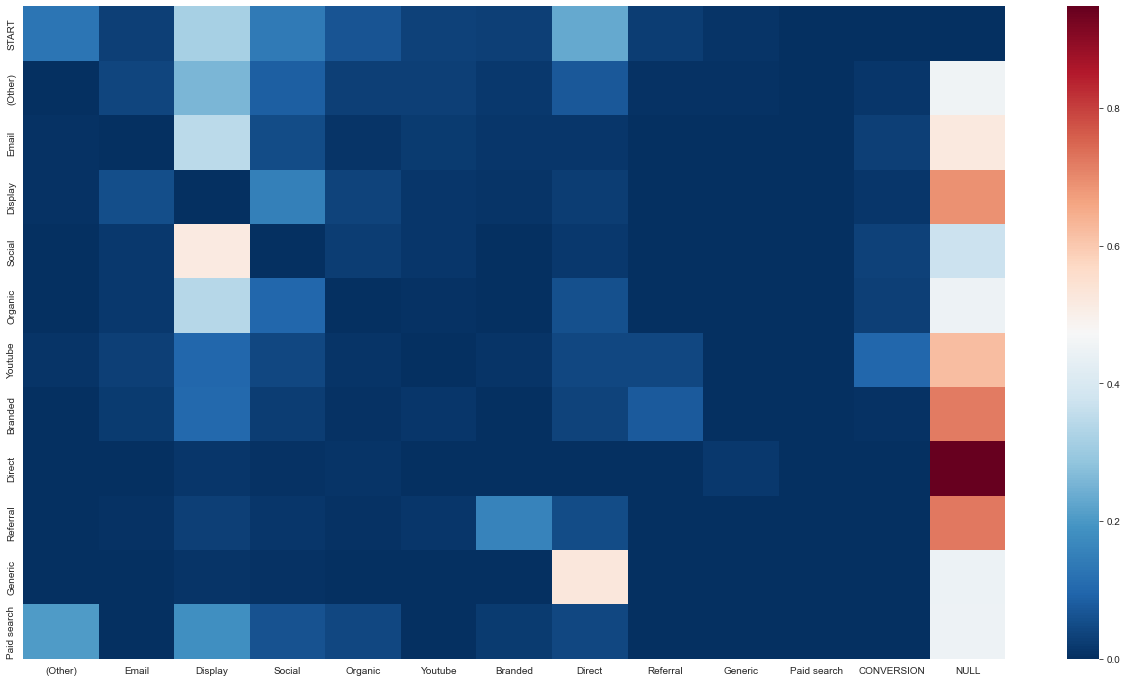

In [191]:
# Create new matrix (empty) with origin and destination channels as columns and index
m2_mm_trans_matrix = pd.DataFrame(columns=channel_to_unique, index=channel_from_unique)
# m2_mm_trans_matrix 

# Assign the probabilities to the corresponding cells in our transition matrix
for f in channel_from_unique:
    for t in channel_to_unique:
        x = m2_mm_transition_probs[(m2_mm_transition_probs['channel_from'] == f) & (m2_mm_transition_probs['channel_to'] == t)]
        prob = x['transition_probability'].values
        if prob.size > 0:
            m2_mm_trans_matrix[t][f] = prob[0]
        else:
            m2_mm_trans_matrix[t][f] = 0

# Convert all probabilities to floats
m2_mm_trans_matrix = m2_mm_trans_matrix.apply(pd.to_numeric)

# Rename our start and conversion events
m2_mm_trans_matrix.rename(index={'0': 'START'}, inplace=True)
m2_mm_trans_matrix.rename(index={'1': '(Other)'}, inplace=True)
m2_mm_trans_matrix.rename(index={'2': 'Email'}, inplace=True)
m2_mm_trans_matrix.rename(index={'3': 'Display'}, inplace=True)
m2_mm_trans_matrix.rename(index={'4': 'Social'}, inplace=True)
m2_mm_trans_matrix.rename(index={'5': 'Organic'}, inplace=True)
m2_mm_trans_matrix.rename(index={'6': 'Youtube'}, inplace=True)
m2_mm_trans_matrix.rename(index={'7': 'Branded'}, inplace=True)
m2_mm_trans_matrix.rename(index={'8': 'Direct'}, inplace=True)
m2_mm_trans_matrix.rename(index={'9': 'Referral'}, inplace=True)
m2_mm_trans_matrix.rename(index={'10': 'Generic'}, inplace=True)
m2_mm_trans_matrix.rename(index={'11': 'Paid search'}, inplace=True)

m2_mm_trans_matrix.rename(columns={'21': 'CONVERSION'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'22': 'NULL'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'0': 'START'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'1': '(Other)'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'2': 'Email'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'3': 'Display'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'4': 'Social'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'5': 'Organic'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'6': 'Youtube'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'7': 'Branded'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'8': 'Direct'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'9': 'Referral'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'10': 'Generic'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'11': 'Paid search'}, inplace=True)

# Visualize this transition matrix in a heatmap
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(22, 12))
sns.heatmap(m2_mm_trans_matrix, cmap="RdBu_r")
plt.show()

In [192]:
m2_mm_trans_matrix

,(Other),Email,Display,Social,Organic,Youtube,Branded,Direct,Referral,Generic,Paid search,CONVERSION,NULL
START,0.125921,0.028911,0.316409,0.139391,0.066198,0.030507,0.027082,0.231576,0.025844,0.007873,0.000287,0.000000,0.000000
(Other),0.000000,0.039929,0.256064,0.081902,0.029436,0.027800,0.015399,0.071818,0.005179,0.004906,0.002180,0.013628,0.451758
Email,0.003963,0.000000,0.344563,0.051028,0.008422,0.019569,0.013872,0.012138,0.000991,0.000248,0.000000,0.026257,0.518950
Display,0.005812,0.054091,0.000000,0.149123,0.035000,0.012305,0.009253,0.025357,0.001623,0.000747,0.000195,0.014351,0.692143
Social,0.003361,0.017091,0.517663,0.000000,0.024457,0.011585,0.003504,0.015446,0.001645,0.000501,0.000143,0.031178,0.373427
Organic,0.001627,0.015371,0.338879,0.098011,0.000000,0.006148,0.003074,0.056058,0.000542,0.002170,0.000362,0.027667,0.450090
Youtube,0.009043,0.027506,0.098342,0.041824,0.009797,0.000000,0.009043,0.042577,0.041824,0.001884,0.000000,0.099472,0.618689
Branded,0.002106,0.018955,0.101095,0.023168,0.005476,0.011373,0.000000,0.034962,0.077085,0.001264,0.000421,0.004634,0.719461
Direct,0.001420,0.000774,0.013358,0.004904,0.007679,0.002646,0.001549,0.000000,0.001613,0.015488,0.000387,0.002452,0.947728
Referral,0.002128,0.006383,0.026596,0.011702,0.003723,0.014362,0.156383,0.051064,0.000000,0.001596,0.000000,0.002128,0.723936


#### Use auto MM


I do not really understand how is the suggested order 5, when 3/4 of paths have a single touchoint

In [111]:
# use auto_markov_model() 
m2_auto_mm = ChannelAttribution.auto_markov_model(Data = df_attribution, 
                                                  var_path = 'Channel group', 
                                                  var_conv = 'Transactions', 
                                                  var_null = 'counter_paths_without_transactions', 
                                                  var_value = 'Transaction revenue',
                                                  plot = True, 
                                                  out_more = True) # return transition matrix 

Suggested order: 5
Number of simulations: 100000 - Reaching convergence (wait...): 14.46% > 5.00%
Number of simulations: 150000 - Reaching convergence (wait...): 14.07% > 5.00%
Number of simulations: 225000 - Reaching convergence (wait...): 13.12% > 5.00%
Number of simulations: 337500 - Reaching convergence (wait...): 10.87% > 5.00%
Number of simulations: 506250 - Reaching convergence (wait...): 9.20% > 5.00%
Number of simulations: 759375 - Reaching convergence (wait...): 6.85% > 5.00%
Number of simulations: 1139062 - Reaching convergence (wait...): 5.39% > 5.00%
Number of simulations: 1708593 - Convergence reached: 4.61% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (133) is reached: 99.99%


In [117]:
result_table = m2_auto_mm['result']
transition_matrix = m2_auto_mm['transition_matrix']
removal_effects = m2_auto_mm['removal_effects']

In [ ]:
# Assign the probabilities to the corresponding cells in our transition matrix
for f in channel_from_unique:
    for t in channel_to_unique:
        x = trans_prob [(trans_prob ['channel_from'] == f) & (trans_prob ['channel_to'] == t)]
        prob = x['transition_probability'].values
        if prob.size > 0:
            trans_matrix[t][f] = prob[0]
        else:
            trans_matrix[t][f] = 0

# Convert all probabilities to floats
trans_matrix = trans_matrix.apply(pd.to_numeric)

# Rename our start and conversion events
trans_matrix.rename(index={'0': 'Start'}, inplace=True)
trans_matrix.rename(columns={'21': 'Conversion'}, inplace=True)

# Visualize this transition matrix in a heatmap
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(22, 12))
sns.heatmap(trans_matrix, cmap="RdBu_r")
plt.show()

In [98]:
m2_auto_mm.rename({'total_conversions':'markov_conversions', 'total_conversion_value':'markov_value'}, axis = 1, inplace = True)
results_models = pd.merge(left = m1_heuristics, right = m2_auto_mm, on = 'channel_name', how = 'left')
print(results_models)
# plot 
plot_data = results_models[['channel_name', 'last_touch_conversions', 'last_touch_value', 'markov_conversions', 'markov_value']]
plot_data.plot(x = 'channel_name', y = ['last_touch_conversions', 'markov_conversions'], kind = 'bar')
plt.show()

,channel_name,first_touch_conversions,first_touch_value,last_touch_conversions,last_touch_value,linear_touch_conversions,linear_touch_value,markov_conversions,markov_value
0,(Other),16.0,2151.00,14.0,1807.00,15.126935,1975.991862,16.244246,1421.121167
1,Email,861.0,84749.64,920.0,100251.46,888.277896,92188.258121,837.481127,91620.018582
2,Display,26.0,3156.50,51.0,5046.50,41.782200,4222.547448,46.326183,5122.123081
3,Social,36.0,2261.00,35.0,2513.00,37.402473,2452.303473,41.513073,3224.043284
4,Organic Search,1640.0,319605.05,1708.0,336122.73,1675.289299,328154.575469,1751.972013,335179.926253
5,YouTube Ads,2.0,275.00,4.0,695.00,3.000000,485.000000,2.406555,522.402424
6,Branded Paid Search,2008.0,395770.21,2010.0,388241.51,2012.809062,393068.111596,1993.229147,386650.303871
7,Direct,904.0,142433.62,781.0,127500.12,839.751151,134431.443821,844.099153,133011.968570
8,Referral,122.0,23213.40,171.0,24734.40,143.719881,23921.590089,167.255570,24357.881500
9,Generic Paid Search,919.0,103831.18,840.0,90534.88,876.841103,96546.778120,834.472933,96546.811266


Results are almost the same for last-touch and Markov, probably because most of our paths just contain one touchpoint (whether ending up in a conversion or not). Therefore, we repeated the study for those with touchpoints > 1

In [ ]:
# extract transition matrix 


In [109]:
m3_auto_mm_more_touchpoints = ChannelAttribution.auto_markov_model(Data = df_attribution_more_touchpoints, var_path = 'Channel group', var_conv = 'Transactions', var_null = 'counter_paths_without_transactions', var_value = 'Transaction revenue')

Suggested order: 4
Number of simulations: 100000 - Reaching convergence (wait...): 10.88% > 5.00%
Number of simulations: 150000 - Reaching convergence (wait...): 8.53% > 5.00%
Number of simulations: 225000 - Reaching convergence (wait...): 6.94% > 5.00%
Number of simulations: 337500 - Reaching convergence (wait...): 5.48% > 5.00%
Number of simulations: 506250 - Reaching convergence (wait...): 5.48% > 5.00%
Number of simulations: 759375 - Reaching convergence (wait...): 5.00% > 5.00%
Number of simulations: 1139062 - Convergence reached: 4.33% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (120) is reached: 99.99%


## Modelling trial III: ML approach 

It tries to classify a path as being successful (conversion) or not (no-conversion), using all available features 

In [55]:
# TODO

Attribution models need paths to be limited by symbol ">" (like in R package)

In [13]:
# modify variable path 
def listToString(df):  
    str1 = ""  
    for i in df['path']:  
        str1 += i + ' > '    
    return str1[:-3]

df_paths['path'] = df_paths.apply(listToString, axis=1)
df_paths.head()

,clientID,path,Transactions,Transaction revenue
0,1000005671.1568444004,Display,0,0.0
1,1000006728.1622927843,Direct,0,0.0
2,1000020259.1556972396,Referral,0,0.0
3,1000023369.1635190743,Referral,0,0.0
4,1000024791.1630470945,Branded Paid Search,0,0.0


`df_paths` is a table that contains one row per unique clientID with features 
* `clientID`
* `path` - complete path, eventhough often just one touchpoint exists 
* `Transactions` 
* `Transaction revenue`

(?) Are transactions the total transactions for those clientIDs with more than one transaction? 

In [23]:
# grouped data of original dataset 
test1 = df_model.sort_values('clientID').groupby('clientID')['Transactions'].sum()
test1 = test1.to_frame()
test1

,Transactions
clientID,
1000005671.1568444004,0
1000006728.1622927843,0
1000020259.1556972396,0
1000023369.1635190743,0
1000024791.1630470945,0
...,...
999973068.1611254848,0
99997309.1608586309,0
999988377.1636720143,0


In [24]:
test2 = df_paths.sort_values('clientID')[['clientID', 'Transactions']]
test2

,clientID,Transactions
0,1000005671.1568444004,0
1,1000006728.1622927843,0
2,1000020259.1556972396,0
3,1000023369.1635190743,0
4,1000024791.1630470945,0
...,...,...
323348,999973068.1611254848,0
323349,99997309.1608586309,0
323350,999988377.1636720143,0
323351,999996741.1623865085,0


In [25]:
# compare test1 and test2 -> specially transactions 
## sum of transactions 
print(test1['Transactions'].sum())
print(test2['Transactions'].sum())

7725
5756


(!) Attention! I think `df_paths()` is not really correct, because clientIDs that had more than one transaction just appear once in the dataset. I think a pretreatment like we did in R would be necessary

## Heurstic approaches 

## Data-driven approaches. Markov Chains